 # Power Load Prediction for West Zone - Ensemble Model (24h)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})

In [2]:
power_data_west = pd.read_csv("westdata_augmented.csv")

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/1727164072.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  power_data_west = pd.read_csv("westdata_augmented.csv")


In [3]:
power_data_west['end'] = pd.to_datetime(power_data_west['end'], infer_datetime_format=True)
indexedDataset = power_data_west.set_index(['end'])

In [4]:
power_data_west['end'].min()

Timestamp('2019-01-29 00:15:00')

In [5]:
power_data_west['end'].max()

Timestamp('2022-01-25 16:00:00')

In [6]:
power_data_west.head()

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,sfm,index_y,dt,dt_iso,humidity,humidity_temp,pt_date
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,2019-01-29 00,680,1548748800,2019-01-29 08,21,63.86,2019-01-29 00
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,2019-01-29 01,681,1548752400,2019-01-29 09,21,63.41,2019-01-29 01


In [7]:
power_data_west['month'] = power_data_west['end'].dt.strftime('%b')

In [8]:
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

# one-liner with Pandas
power_data_west['month_int'] = power_data_west['month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

In [9]:
power_data_west['day_of_week'] = power_data_west['end'].dt.day_name()

In [10]:
power_data_west['day_of_week_int'] = power_data_west['end'].dt.day_of_week

In [11]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

date_range = pd.date_range(start='2019-01-01', end='2022-01-27')

cal = calendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

power_data_west['holiday'] = power_data_west['end'].dt.date.astype('datetime64').isin(holidays)

In [12]:
power_data_west["holiday_int"] = power_data_west["holiday"].astype(int)

In [13]:
power_data_west_mod = power_data_west[['end','demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [14]:
power_data_west_mod.head()

,end,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,2019-01-29 00:15:00,844.8,54.0,21,1,1,0
1,2019-01-29 00:30:00,841.6,54.0,21,1,1,0
2,2019-01-29 00:45:00,832.0,54.0,21,1,1,0
3,2019-01-29 01:00:00,848.0,54.0,21,1,1,0
4,2019-01-29 01:15:00,812.8,55.0,21,1,1,0


In [15]:
power_data_west_mod.describe()

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
count,104596.000000,104588.00000,104608.000000,104608.00000,104608.000000,104608.000000
mean,1238.634456,67.39232,52.635401,6.54298,2.998748,0.028449
std,302.399419,16.59371,22.815913,3.43464,2.002753,0.166253
min,0.000000,29.00000,3.000000,1.00000,0.000000,0.000000
25%,1008.000000,54.00000,34.000000,4.00000,1.000000,0.000000
50%,1232.000000,66.00000,49.000000,7.00000,3.000000,0.000000
75%,1472.000000,79.00000,70.000000,10.00000,5.000000,0.000000
max,2124.800000,114.00000,100.000000,12.00000,6.000000,1.000000


In [17]:
power_data_west['end_val'] = power_data_west.index.values
power_data_west

,Unnamed: 0,index_x,service,start,end,usage,cost,temp,event_flag,demand,...,humidity,humidity_temp,pt_date,month,month_int,day_of_week,day_of_week_int,holiday,holiday_int,end_val
0,0,0,west,2019-01-29 00:00:00,2019-01-29 00:15:00,211.2,NaN,54.0,NaN,844.8,...,21,63.86,2019-01-29 00,Jan,1,Tuesday,1,False,0,0
1,1,1,west,2019-01-29 00:15:00,2019-01-29 00:30:00,210.4,NaN,54.0,NaN,841.6,...,21,63.86,2019-01-29 00,Jan,1,Tuesday,1,False,0,1
2,2,2,west,2019-01-29 00:30:00,2019-01-29 00:45:00,208.0,NaN,54.0,NaN,832.0,...,21,63.86,2019-01-29 00,Jan,1,Tuesday,1,False,0,2
3,3,3,west,2019-01-29 00:45:00,2019-01-29 01:00:00,212.0,NaN,54.0,NaN,848.0,...,21,63.86,2019-01-29 00,Jan,1,Tuesday,1,False,0,3
4,4,4,west,2019-01-29 01:00:00,2019-01-29 01:15:00,203.2,NaN,55.0,NaN,812.8,...,21,63.41,2019-01-29 01,Jan,1,Tuesday,1,False,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104603,104603,104603,west,2022-01-25 14:45:00,2022-01-25 15:00:00,297.6,NaN,67.0,NaN,1190.4,...,27,69.22,2022-01-25 14,Jan,1,Tuesday,1,False,0,104603
104604,104604,104604,west,2022-01-25 15:00:00,2022-01-25 15:15:00,295.2,NaN,67.0,NaN,1180.8,...,26,68.34,2022-01-25 15,Jan,1,Tuesday,1,False,0,104604
104605,104605,104605,west,2022-01-25 15:15:00,2022-01-25 15:30:00,304.8,NaN,67.0,NaN,1219.2,...,26,68.34,2022-01-25 15,Jan,1,Tuesday,1,False,0,104605
104606,104606,104606,west,2022-01-25 15:30:00,2022-01-25 15:45:00,309.6,NaN,67.0,NaN,1238.4,...,26,68.34,2022-01-25 15,Jan,1,Tuesday,1,False,0,104606


In [84]:
linear_data = power_data_west[(power_data_west['end'] > '2019-01-01') & (power_data_west['end'] < '2022-02-01')]
linear_data_mod = linear_data[['demand', 'temp', 'humidity', 'month_int', 'day_of_week_int', 'holiday_int']].copy() 

In [85]:
linear_data_mod.head(10)

,demand,temp,humidity,month_int,day_of_week_int,holiday_int
0,844.8,54.0,21,1,1,0
1,841.6,54.0,21,1,1,0
2,832.0,54.0,21,1,1,0
3,848.0,54.0,21,1,1,0
4,812.8,55.0,21,1,1,0
5,822.4,55.0,21,1,1,0
6,822.4,55.0,21,1,1,0
7,835.2,55.0,21,1,1,0
8,870.4,55.0,22,1,1,0
9,918.4,55.0,22,1,1,0


In [86]:
for i in range(1, 960):
    linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
    linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
    linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["temp_lag_{}".format(i)] = linear_data_mod['temp'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fra

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["humidity_lag_{}".format(i)] = linear_data_mod['humidity'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  linear_data_mod["demand_lag_{}".format(i)] = linear_data_mod['demand'].shift(i)
/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/863251574.py:3: PerformanceWarning: DataFrame is hi

In [87]:
linear_data_mod = linear_data_mod.dropna()

In [89]:
ensemble_data_train = linear_data_mod.head(72519)
ensemble_data_train

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,demand_lag_1,temp_lag_1,humidity_lag_1,demand_lag_2,...,humidity_lag_956,demand_lag_957,temp_lag_957,humidity_lag_957,demand_lag_958,temp_lag_958,humidity_lag_958,demand_lag_959,temp_lag_959,humidity_lag_959
959,800.0,44.0,64,2,4,0,822.4,44.0,64.0,822.4,...,21.0,832.0,54.0,21.0,841.6,54.0,21.0,844.8,54.0,21.0
960,780.8,42.0,70,2,4,0,800.0,44.0,64.0,822.4,...,21.0,848.0,54.0,21.0,832.0,54.0,21.0,841.6,54.0,21.0
961,768.0,42.0,70,2,4,0,780.8,42.0,70.0,800.0,...,21.0,812.8,55.0,21.0,848.0,54.0,21.0,832.0,54.0,21.0
962,726.4,42.0,70,2,4,0,768.0,42.0,70.0,780.8,...,21.0,822.4,55.0,21.0,812.8,55.0,21.0,848.0,54.0,21.0
963,742.4,42.0,70,2,4,0,726.4,42.0,70.0,768.0,...,21.0,822.4,55.0,21.0,822.4,55.0,21.0,812.8,55.0,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79251,1590.4,89.0,36,5,1,0,1488.0,89.0,36.0,1542.4,...,51.0,1148.8,76.0,51.0,1142.4,76.0,51.0,1120.0,76.0,51.0
79252,1606.4,91.0,36,5,1,0,1590.4,89.0,36.0,1488.0,...,51.0,1136.0,76.0,51.0,1148.8,76.0,51.0,1142.4,76.0,51.0
79253,1609.6,91.0,36,5,1,0,1606.4,91.0,36.0,1590.4,...,51.0,1158.4,77.0,51.0,1136.0,76.0,51.0,1148.8,76.0,51.0
79254,1552.0,91.0,36,5,1,0,1609.6,91.0,36.0,1606.4,...,51.0,1180.8,77.0,51.0,1158.4,77.0,51.0,1136.0,76.0,51.0


In [90]:
ensemble_data_test = linear_data_mod.tail(31080)
ensemble_data_test

,demand,temp,humidity,month_int,day_of_week_int,holiday_int,demand_lag_1,temp_lag_1,humidity_lag_1,demand_lag_2,...,humidity_lag_956,demand_lag_957,temp_lag_957,humidity_lag_957,demand_lag_958,temp_lag_958,humidity_lag_958,demand_lag_959,temp_lag_959,humidity_lag_959
71602,1107.2,43.0,96,2,5,0,1139.2,43.0,96.0,1184.0,...,67.0,1321.6,50.0,67.0,1305.6,50.0,67.0,1321.6,53.0,67.0
71603,1046.4,43.0,96,2,5,0,1107.2,43.0,96.0,1139.2,...,67.0,1312.0,50.0,67.0,1321.6,50.0,67.0,1305.6,50.0,67.0
71604,960.0,43.0,94,2,5,0,1046.4,43.0,96.0,1107.2,...,71.0,1331.2,50.0,67.0,1312.0,50.0,67.0,1321.6,50.0,67.0
71605,937.6,43.0,94,2,5,0,960.0,43.0,94.0,1046.4,...,71.0,1280.0,49.0,71.0,1331.2,50.0,67.0,1312.0,50.0,67.0
71606,947.2,43.0,94,2,5,0,937.6,43.0,94.0,960.0,...,71.0,1280.0,49.0,71.0,1280.0,49.0,71.0,1331.2,50.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104603,1190.4,67.0,27,1,1,0,1190.4,67.0,27.0,1238.4,...,27.0,1283.2,66.0,27.0,1244.8,66.0,27.0,1168.0,66.0,27.0
104604,1180.8,67.0,26,1,1,0,1190.4,67.0,27.0,1190.4,...,25.0,1251.2,66.0,27.0,1283.2,66.0,27.0,1244.8,66.0,27.0
104605,1219.2,67.0,26,1,1,0,1180.8,67.0,26.0,1190.4,...,25.0,1209.6,63.0,25.0,1251.2,66.0,27.0,1283.2,66.0,27.0
104606,1238.4,67.0,26,1,1,0,1219.2,67.0,26.0,1180.8,...,25.0,1235.2,63.0,25.0,1209.6,63.0,25.0,1251.2,66.0,27.0


## Ensemble Model - Analysis

In [202]:
linear_model_test_results = pd.read_csv("15m_Linear_Model_Test_Results.csv")

In [203]:
linear_model_test_results

,Unnamed: 0,Actual,Prediction,month_int,day_of_week_int,holiday_int,residual
0,73494,1424.0,1286.907179,3,4,0,137.092821
1,73495,1344.0,1413.916271,3,4,0,-69.916271
2,73496,1347.2,1321.246602,3,4,0,25.953398
3,73497,1414.4,1351.572210,3,4,0,62.827790
4,73498,1328.0,1389.720842,3,4,0,-61.720842
...,...,...,...,...,...,...,...
31075,104603,1190.4,1206.450109,1,1,0,-16.050109
31076,104604,1180.8,1199.659766,1,1,0,-18.859766
31077,104605,1219.2,1184.593952,1,1,0,34.606048
31078,104606,1238.4,1219.888330,1,1,0,18.511670


In [204]:
linear_model_test_results['model'] = 'Linear Model'
linear_model_test_results['end'] = linear_model_test_results.index.values
linear_model_test_results

,Unnamed: 0,Actual,Prediction,month_int,day_of_week_int,holiday_int,residual,model,end
0,73494,1424.0,1286.907179,3,4,0,137.092821,Linear Model,0
1,73495,1344.0,1413.916271,3,4,0,-69.916271,Linear Model,1
2,73496,1347.2,1321.246602,3,4,0,25.953398,Linear Model,2
3,73497,1414.4,1351.572210,3,4,0,62.827790,Linear Model,3
4,73498,1328.0,1389.720842,3,4,0,-61.720842,Linear Model,4
...,...,...,...,...,...,...,...,...,...
31075,104603,1190.4,1206.450109,1,1,0,-16.050109,Linear Model,31075
31076,104604,1180.8,1199.659766,1,1,0,-18.859766,Linear Model,31076
31077,104605,1219.2,1184.593952,1,1,0,34.606048,Linear Model,31077
31078,104606,1238.4,1219.888330,1,1,0,18.511670,Linear Model,31078


In [60]:
gru_model_test_results = pd.read_csv("15m_GRU_Model_Test_Results.csv")

In [170]:
gru_model_test_results

,Unnamed: 0,Actual,Prediction,residual,model,end
0,0,1225.6,1221.8715,3.7285,GRU,0
1,1,1200.0,1246.4957,-46.4957,GRU,1
2,2,1177.6,1225.5170,-47.9170,GRU,2
3,3,1171.2,1211.9889,-40.7889,GRU,3
4,4,1164.8,1202.9658,-38.1658,GRU,4
...,...,...,...,...,...,...
33512,33512,1190.4,1261.2767,-70.8767,GRU,33512
33513,33513,1190.4,1225.0797,-34.6797,GRU,33513
33514,33514,1180.8,1227.6573,-46.8573,GRU,33514
33515,33515,1219.2,1214.8575,4.3425,GRU,33515


In [62]:
gru_model_test_results['Actual'] = gru_model_test_results['Actual Peak Demand']
gru_model_test_results = gru_model_test_results.drop(['Actual Peak Demand'], axis=1)
gru_model_test_results['Prediction'] = gru_model_test_results['Predicted Peak Demand']
gru_model_test_results = gru_model_test_results.drop(['Predicted Peak Demand'], axis=1)
gru_model_test_results['residual'] = gru_model_test_results['Actual'] - gru_model_test_results['Prediction']
gru_model_test_results['model'] = 'GRU'
gru_model_test_results['end'] = gru_model_test_results.index.values
gru_model_test_results

,Unnamed: 0,Actual,Prediction,residual,model,end
0,0,1225.6,1221.8715,3.7285,GRU,0
1,1,1200.0,1246.4957,-46.4957,GRU,1
2,2,1177.6,1225.5170,-47.9170,GRU,2
3,3,1171.2,1211.9889,-40.7889,GRU,3
4,4,1164.8,1202.9658,-38.1658,GRU,4
...,...,...,...,...,...,...
33512,33512,1190.4,1261.2767,-70.8767,GRU,33512
33513,33513,1190.4,1225.0797,-34.6797,GRU,33513
33514,33514,1180.8,1227.6573,-46.8573,GRU,33514
33515,33515,1219.2,1214.8575,4.3425,GRU,33515


In [197]:
randomforest_model_test_results = pd.read_csv("15m_RandomForest_Model_Test_Results.csv")

In [198]:
randomforest_model_test_results

,Unnamed: 0,Actual,Prediction
0,73494,1424.0,1290.1440
1,73495,1344.0,1403.8400
2,73496,1347.2,1324.1216
3,73497,1414.4,1352.1664
4,73498,1328.0,1372.2496
...,...,...,...
31075,104603,1190.4,1192.0128
31076,104604,1180.8,1210.3488
31077,104605,1219.2,1186.1504
31078,104606,1238.4,1225.4304


In [199]:
randomforest_model_test_results['residual'] = randomforest_model_test_results['Actual'] - randomforest_model_test_results['Prediction']
randomforest_model_test_results['model'] = 'Random Forest'
randomforest_model_test_results['end'] = randomforest_model_test_results.index.values
randomforest_model_test_results

,Unnamed: 0,Actual,Prediction,residual,model,end
0,73494,1424.0,1290.1440,133.8560,Random Forest,0
1,73495,1344.0,1403.8400,-59.8400,Random Forest,1
2,73496,1347.2,1324.1216,23.0784,Random Forest,2
3,73497,1414.4,1352.1664,62.2336,Random Forest,3
4,73498,1328.0,1372.2496,-44.2496,Random Forest,4
...,...,...,...,...,...,...
31075,104603,1190.4,1192.0128,-1.6128,Random Forest,31075
31076,104604,1180.8,1210.3488,-29.5488,Random Forest,31076
31077,104605,1219.2,1186.1504,33.0496,Random Forest,31077
31078,104606,1238.4,1225.4304,12.9696,Random Forest,31078


In [30]:
XGBoost_model_test_results = pd.read_csv("15m_XGBoost_Model_Test_Results.csv")

In [31]:
XGBoost_model_test_results

,Unnamed: 0,Actual,Prediction
0,73494,1424.0,1302.4258
1,73495,1344.0,1324.5574
2,73496,1347.2,1286.7960
3,73497,1414.4,1339.8046
4,73498,1328.0,1349.4198
...,...,...,...
31075,104603,1190.4,1214.5984
31076,104604,1180.8,1216.7394
31077,104605,1219.2,1193.2067
31078,104606,1238.4,1221.9025


In [32]:
XGBoost_model_test_results['residual'] = XGBoost_model_test_results['Actual'] - XGBoost_model_test_results['Prediction']
XGBoost_model_test_results['model'] = 'XG Boost'
XGBoost_model_test_results['end'] = XGBoost_model_test_results.index.values
XGBoost_model_test_results

,Unnamed: 0,Actual,Prediction,residual,model,end
0,73494,1424.0,1302.4258,121.5742,XG Boost,0
1,73495,1344.0,1324.5574,19.4426,XG Boost,1
2,73496,1347.2,1286.7960,60.4040,XG Boost,2
3,73497,1414.4,1339.8046,74.5954,XG Boost,3
4,73498,1328.0,1349.4198,-21.4198,XG Boost,4
...,...,...,...,...,...,...
31075,104603,1190.4,1214.5984,-24.1984,XG Boost,31075
31076,104604,1180.8,1216.7394,-35.9394,XG Boost,31076
31077,104605,1219.2,1193.2067,25.9933,XG Boost,31077
31078,104606,1238.4,1221.9025,16.4975,XG Boost,31078


In [57]:
LSTM_model_test_results = pd.read_csv("15m_LSTM_Model_Test_Results.csv")

In [58]:
LSTM_model_test_results

,Unnamed: 0,Actual Peak Demand,Predicted Peak Demand
0,0,1225.6,1213.8210
1,1,1200.0,1236.2686
2,2,1177.6,1216.1337
3,3,1171.2,1203.1069
4,4,1164.8,1195.4879
...,...,...,...
33512,33512,1190.4,1255.4481
33513,33513,1190.4,1225.6702
33514,33514,1180.8,1226.7759
33515,33515,1219.2,1215.5876


In [59]:
LSTM_model_test_results['Actual'] = LSTM_model_test_results['Actual Peak Demand']
LSTM_model_test_results = LSTM_model_test_results.drop(['Actual Peak Demand'], axis=1)
LSTM_model_test_results['Prediction'] = LSTM_model_test_results['Predicted Peak Demand']
LSTM_model_test_results = LSTM_model_test_results.drop(['Predicted Peak Demand'], axis=1)
LSTM_model_test_results['residual'] = LSTM_model_test_results['Actual'] - LSTM_model_test_results['Prediction']
LSTM_model_test_results['model'] = 'LSTM'
LSTM_model_test_results['end'] = LSTM_model_test_results.index.values
LSTM_model_test_results

,Unnamed: 0,Actual,Prediction,residual,model,end
0,0,1225.6,1213.8210,11.7790,LSTM,0
1,1,1200.0,1236.2686,-36.2686,LSTM,1
2,2,1177.6,1216.1337,-38.5337,LSTM,2
3,3,1171.2,1203.1069,-31.9069,LSTM,3
4,4,1164.8,1195.4879,-30.6879,LSTM,4
...,...,...,...,...,...,...
33512,33512,1190.4,1255.4481,-65.0481,LSTM,33512
33513,33513,1190.4,1225.6702,-35.2702,LSTM,33513
33514,33514,1180.8,1226.7759,-45.9759,LSTM,33514
33515,33515,1219.2,1215.5876,3.6124,LSTM,33515


In [186]:
linear_model_test_results[linear_model_test_results['Actual'] == 1164.8]

,Unnamed: 0,Actual,Prediction,residual,model,end
332,73826,1164.8,1155.774153,9.025847,Linear Model,332
340,73834,1164.8,1140.537304,24.262696,Linear Model,340
352,73846,1164.8,1150.208565,14.591435,Linear Model,352
353,73847,1164.8,1187.891212,-23.091212,Linear Model,353
541,74035,1164.8,1231.843246,-67.043246,Linear Model,541
...,...,...,...,...,...,...
30636,104164,1164.8,1159.240549,5.559451,Linear Model,30636
30643,104171,1164.8,1187.204080,-22.404080,Linear Model,30643
30688,104216,1164.8,1161.286533,3.513467,Linear Model,30688
30719,104247,1164.8,1194.622443,-29.822443,Linear Model,30719


In [182]:
linear_model_test_results.iloc[30445:30447,:]

,Unnamed: 0,Actual,Prediction,residual,model,end
30445,103973,1225.6,1260.621611,-35.021611,Linear Model,30445
30446,103974,1193.6,1222.075777,-28.475777,Linear Model,30446


In [63]:
test_results =pd.concat([linear_model_test_results, gru_model_test_results, randomforest_model_test_results, XGBoost_model_test_results, LSTM_model_test_results], axis=0)

In [64]:
test_results['MAPE'] = (abs(test_results['Actual'] - test_results['Prediction'])/test_results['Prediction'] ) *100
test_results['MAE'] = abs(test_results['Actual'] - test_results['Prediction'])

In [65]:
test_results

,Unnamed: 0,Actual,Prediction,residual,model,end,MAPE,MAE
0,73494,1424.0,1286.907179,137.092821,Linear Model,0,10.652891,137.092821
1,73495,1344.0,1413.916271,-69.916271,Linear Model,1,4.944866,69.916271
2,73496,1347.2,1321.246602,25.953398,Linear Model,2,1.964311,25.953398
3,73497,1414.4,1351.572210,62.827790,Linear Model,3,4.648497,62.827790
4,73498,1328.0,1389.720842,-61.720842,Linear Model,4,4.441240,61.720842
...,...,...,...,...,...,...,...,...
33512,33512,1190.4,1255.448100,-65.048100,LSTM,33512,5.181266,65.048100
33513,33513,1190.4,1225.670200,-35.270200,LSTM,33513,2.877626,35.270200
33514,33514,1180.8,1226.775900,-45.975900,LSTM,33514,3.747702,45.975900
33515,33515,1219.2,1215.587600,3.612400,LSTM,33515,0.297173,3.612400


/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAPE'>

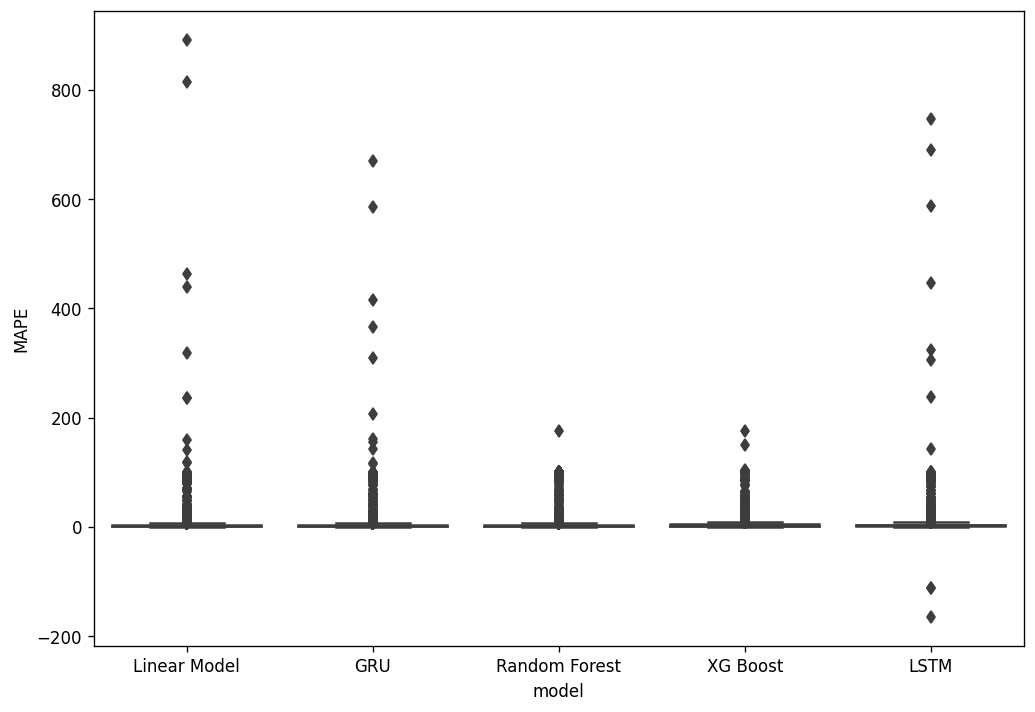

In [66]:
from seaborn import boxplot

boxplot(test_results['model'], test_results['MAPE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='residual'>

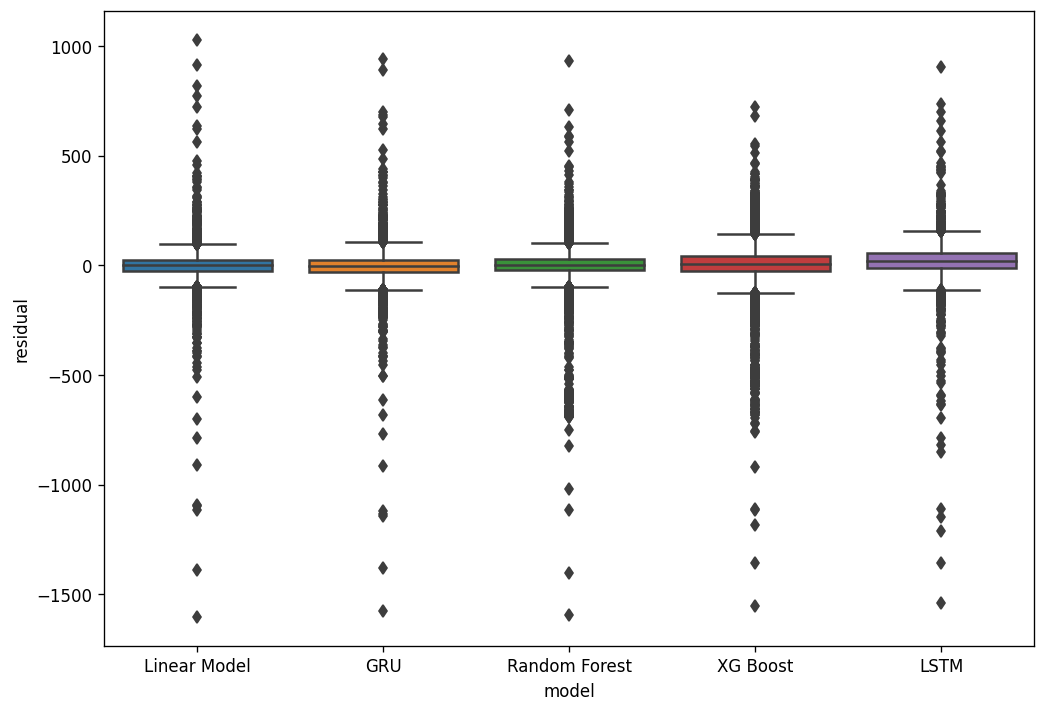

In [67]:
boxplot(test_results['model'], test_results['residual'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAE'>

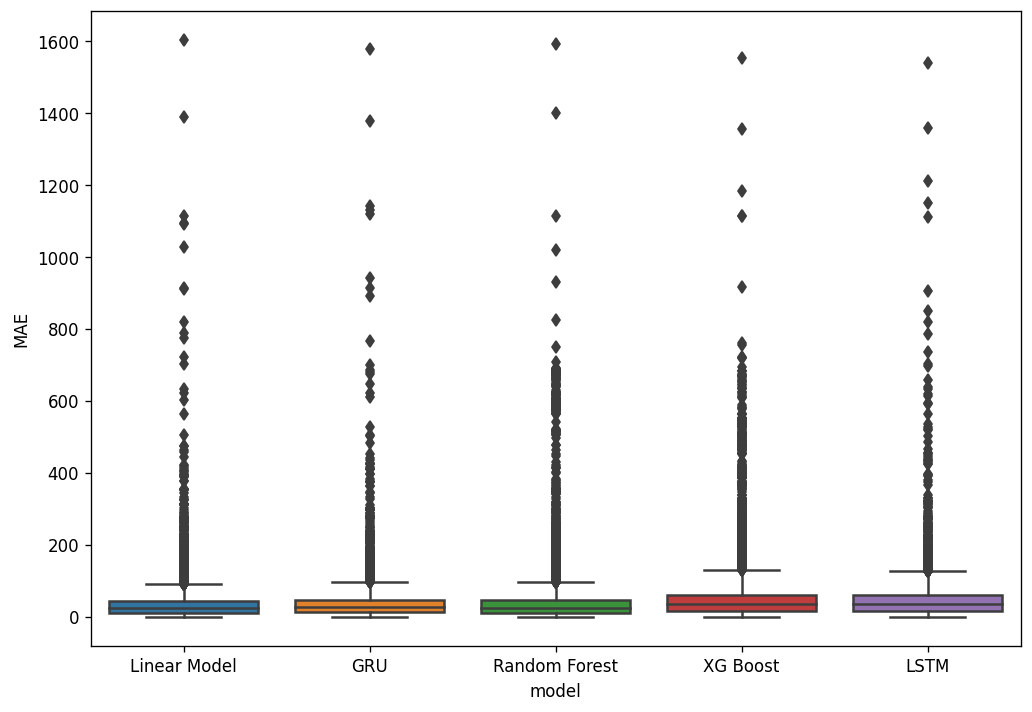

In [68]:
boxplot(test_results['model'], test_results['MAE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Prediction'>

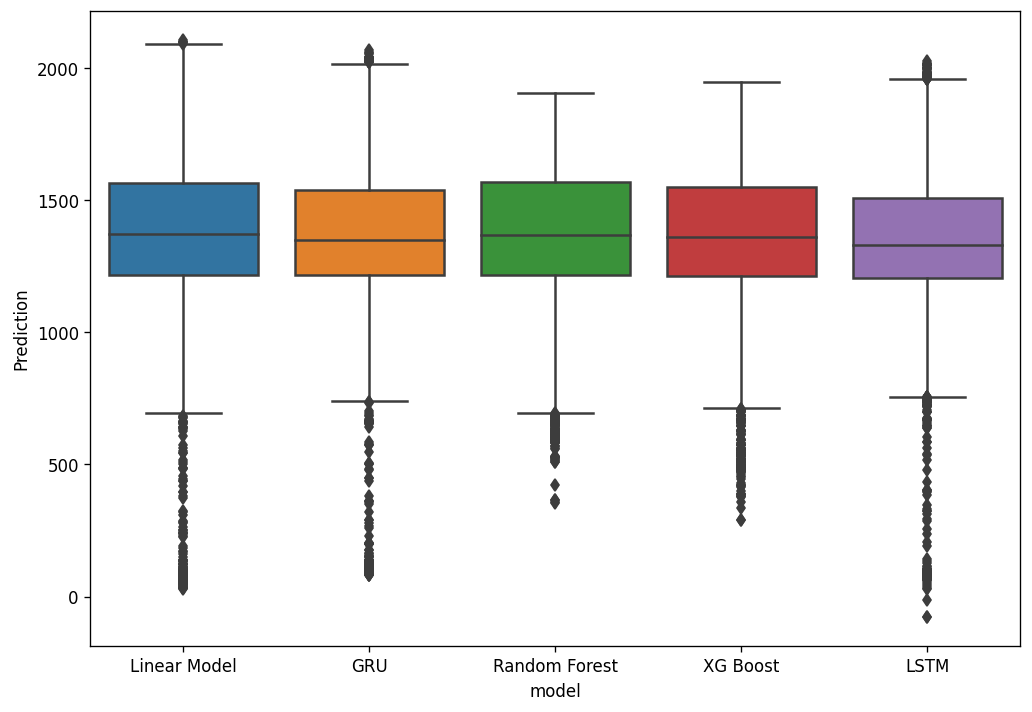

In [69]:
boxplot(test_results['model'], test_results['Prediction'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Actual'>

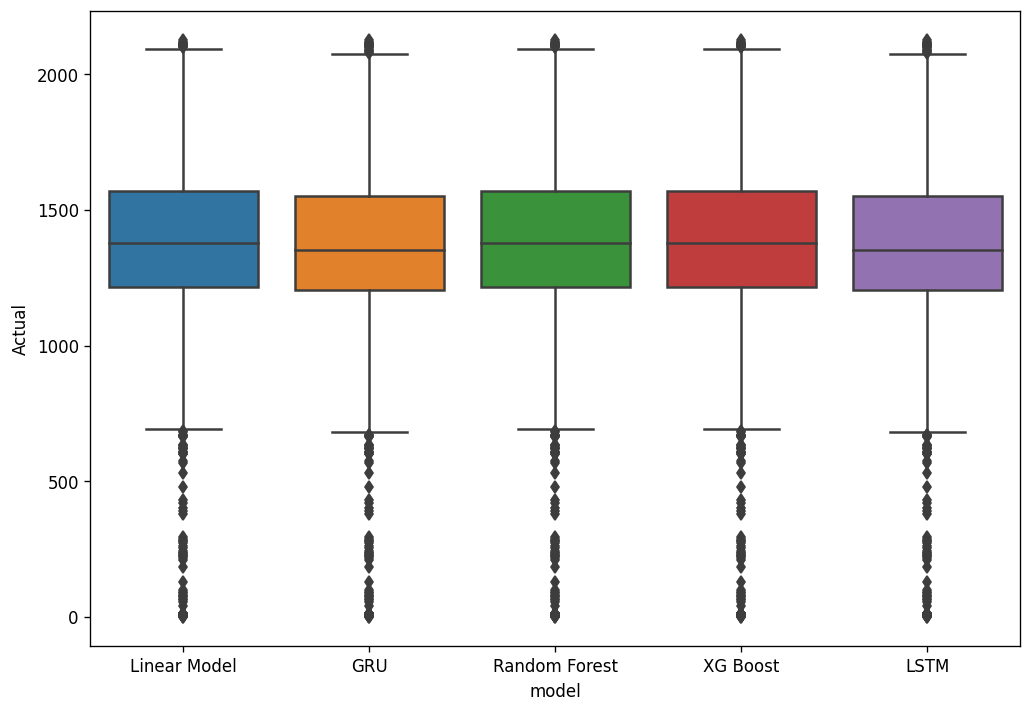

In [70]:
boxplot(test_results['model'], test_results['Actual'])

## Ensemble Model

In [134]:
linear_model_train_results = pd.read_csv("15m_Linear_Model_Train_Results.csv")
linear_model_train_results

,Unnamed: 0,Actual,Prediction,month_int,day_of_week_int,holiday_int,residual
0,959,800.0,814.695119,2,4,0,-14.695119
1,960,780.8,801.612077,2,4,0,-20.812077
2,961,768.0,788.519932,2,4,0,-20.519932
3,962,726.4,781.541090,2,4,0,-55.141090
4,963,742.4,751.124622,2,4,0,-8.724622
...,...,...,...,...,...,...,...
72514,73489,1356.8,1328.378583,3,4,0,28.421417
72515,73490,1340.8,1352.038439,3,4,0,-11.238439
72516,73491,1379.2,1354.955423,3,4,0,24.244577
72517,73492,1433.6,1380.977731,3,4,0,52.622269


In [79]:
gru_model_train_results = pd.read_csv("15m_GRU_Model_Train_Results.csv")
gru_model_train_results

,Unnamed: 0,Actual Peak Demand,Predicted Peak Demand
0,0,780.8,843.56320
1,1,768.0,827.31793
2,2,726.4,815.07520
3,3,742.4,780.47320
4,4,742.4,790.92950
...,...,...,...
70075,70075,1193.6,1206.77050
70076,70076,1235.2,1226.03820
70077,70077,1212.8,1252.17400
70078,70078,1209.6,1236.66360


In [80]:
gru_model_train_results['Actual'] = gru_model_train_results['Actual Peak Demand']
gru_model_train_results = gru_model_train_results.drop(['Actual Peak Demand'], axis=1)
gru_model_train_results['Prediction'] = gru_model_train_results['Predicted Peak Demand']
gru_model_train_results = gru_model_train_results.drop(['Predicted Peak Demand'], axis=1)
gru_model_train_results

,Unnamed: 0,Actual,Prediction
0,0,780.8,843.56320
1,1,768.0,827.31793
2,2,726.4,815.07520
3,3,742.4,780.47320
4,4,742.4,790.92950
...,...,...,...
70075,70075,1193.6,1206.77050
70076,70076,1235.2,1226.03820
70077,70077,1212.8,1252.17400
70078,70078,1209.6,1236.66360


In [73]:
randomforest_model_train_results = pd.read_csv("15m_RandomForest_Model_Train_Results.csv")
randomforest_model_train_results

,Unnamed: 0,Actual,Prediction
0,959,800.0,805.52320
1,960,780.8,789.00480
2,961,768.0,778.45760
3,962,726.4,743.72480
4,963,742.4,742.64294
...,...,...,...
72514,73489,1356.8,1350.04800
72515,73490,1340.8,1339.92960
72516,73491,1379.2,1361.62560
72517,73492,1433.6,1396.90240


In [74]:
XGBoost_model_train_results = pd.read_csv("15m_XGBoost_Model_Train_Results.csv")
XGBoost_model_train_results

,Unnamed: 0,Actual,Prediction
0,959,800.0,799.10920
1,960,780.8,779.28064
2,961,768.0,767.79944
3,962,726.4,729.60080
4,963,742.4,740.90845
...,...,...,...
72514,73489,1356.8,1355.87240
72515,73490,1340.8,1342.90820
72516,73491,1379.2,1379.43180
72517,73492,1433.6,1429.04930


In [75]:
LSTM_model_train_results = pd.read_csv("15m_LSTM_Model_Train_Results.csv")
LSTM_model_train_results

,Unnamed: 0,Actual Peak Demand,Predicted Peak Demand
0,0,780.8,838.37177
1,1,768.0,821.59500
2,2,726.4,808.73090
3,3,742.4,772.91820
4,4,742.4,782.86206
...,...,...,...
70075,70075,1193.6,1199.83280
70076,70076,1235.2,1218.71920
70077,70077,1212.8,1241.32450
70078,70078,1209.6,1225.90800


In [81]:
LSTM_model_train_results['Actual'] = LSTM_model_train_results['Actual Peak Demand']
LSTM_model_train_results = LSTM_model_train_results.drop(['Actual Peak Demand'], axis=1)
LSTM_model_train_results['Prediction'] = LSTM_model_train_results['Predicted Peak Demand']
LSTM_model_train_results = LSTM_model_train_results.drop(['Predicted Peak Demand'], axis=1)
LSTM_model_train_results

,Unnamed: 0,Actual,Prediction
0,0,780.8,838.37177
1,1,768.0,821.59500
2,2,726.4,808.73090
3,3,742.4,772.91820
4,4,742.4,782.86206
...,...,...,...
70075,70075,1193.6,1199.83280
70076,70076,1235.2,1218.71920
70077,70077,1212.8,1241.32450
70078,70078,1209.6,1225.90800


In [135]:
linear_model_train_results_mod = linear_model_train_results.head(70081)
linear_model_train_results_mod.drop([0], axis=0, inplace=True)
linear_model_train_results_mod

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/4099084790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  linear_model_train_results_mod.drop([0], axis=0, inplace=True)


,Unnamed: 0,Actual,Prediction,month_int,day_of_week_int,holiday_int,residual
1,960,780.8,801.612077,2,4,0,-20.812077
2,961,768.0,788.519932,2,4,0,-20.519932
3,962,726.4,781.541090,2,4,0,-55.141090
4,963,742.4,751.124622,2,4,0,-8.724622
5,964,742.4,729.050929,2,4,0,13.349071
...,...,...,...,...,...,...,...
70076,71051,1193.6,1172.640003,2,6,0,20.959997
70077,71052,1235.2,1198.757955,2,6,0,36.442045
70078,71053,1212.8,1200.325617,2,6,0,12.474383
70079,71054,1209.6,1204.575179,2,6,0,5.024821


In [105]:
randomforest_model_train_results_mod = randomforest_model_train_results.head(70081)
randomforest_model_train_results_mod.drop([0], axis=0, inplace=True)
randomforest_model_train_results_mod

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/3911806484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  randomforest_model_train_results_mod.drop([0], axis=0, inplace=True)


,Unnamed: 0,Actual,Prediction
1,960,780.8,789.00480
2,961,768.0,778.45760
3,962,726.4,743.72480
4,963,742.4,742.64294
5,964,742.4,747.71840
...,...,...,...
70076,71051,1193.6,1183.54560
70077,71052,1235.2,1221.82400
70078,71053,1212.8,1214.63680
70079,71054,1209.6,1206.25920


In [107]:
XGBoost_model_train_results_mod = XGBoost_model_train_results.head(70081)
XGBoost_model_train_results_mod.drop([0], axis=0, inplace=True)
XGBoost_model_train_results_mod

/var/folders/7y/xgxlym8j2wvcdq_3kmlw40zm0000gn/T/ipykernel_16137/3186847299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XGBoost_model_train_results_mod.drop([0], axis=0, inplace=True)


,Unnamed: 0,Actual,Prediction
1,960,780.8,779.28064
2,961,768.0,767.79944
3,962,726.4,729.60080
4,963,742.4,740.90845
5,964,742.4,743.81946
...,...,...,...
70076,71051,1193.6,1192.84990
70077,71052,1235.2,1233.99770
70078,71053,1212.8,1213.56510
70079,71054,1209.6,1208.69420


In [136]:
ensemble_train = pd.DataFrame({ 
                               'Linear_Actual':linear_model_train_results_mod['Actual'].to_numpy(),
                               'Linear_Prediction':linear_model_train_results_mod['Prediction'] .to_numpy(),
    
                               'GRU_Actual':gru_model_train_results['Actual'].to_numpy(),
                               'GRU_Prediction':gru_model_train_results['Prediction'] .to_numpy(),
    
                               'RandomForest_Actual':randomforest_model_train_results_mod['Actual'].to_numpy(),
                               'RandomForest_Prediction':randomforest_model_train_results_mod['Prediction'].to_numpy(),
    
                               'XGBoost_Actual':XGBoost_model_train_results_mod['Actual'].to_numpy(),
                               'XGBoost_Prediction':XGBoost_model_train_results_mod['Prediction'].to_numpy(),
        
                               'LSTM_Actual':LSTM_model_train_results['Actual'].to_numpy(),
                               'LSTM_Prediction':LSTM_model_train_results['Prediction'].to_numpy(),
    
                               'month_int':linear_model_train_results_mod['month_int'].to_numpy(),
                               'day_of_week_int':linear_model_train_results_mod['day_of_week_int'].to_numpy(),
                               'holiday_int':linear_model_train_results_mod['holiday_int'].to_numpy(),
                                
                             })

ensemble_train

,Linear_Actual,Linear_Prediction,GRU_Actual,GRU_Prediction,RandomForest_Actual,RandomForest_Prediction,XGBoost_Actual,XGBoost_Prediction,LSTM_Actual,LSTM_Prediction,month_int,day_of_week_int,holiday_int
0,780.8,801.612077,780.8,843.56320,780.8,789.00480,780.8,779.28064,780.8,838.37177,2,4,0
1,768.0,788.519932,768.0,827.31793,768.0,778.45760,768.0,767.79944,768.0,821.59500,2,4,0
2,726.4,781.541090,726.4,815.07520,726.4,743.72480,726.4,729.60080,726.4,808.73090,2,4,0
3,742.4,751.124622,742.4,780.47320,742.4,742.64294,742.4,740.90845,742.4,772.91820,2,4,0
4,742.4,729.050929,742.4,790.92950,742.4,747.71840,742.4,743.81946,742.4,782.86206,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70075,1193.6,1172.640003,1193.6,1206.77050,1193.6,1183.54560,1193.6,1192.84990,1193.6,1199.83280,2,6,0
70076,1235.2,1198.757955,1235.2,1226.03820,1235.2,1221.82400,1235.2,1233.99770,1235.2,1218.71920,2,6,0
70077,1212.8,1200.325617,1212.8,1252.17400,1212.8,1214.63680,1212.8,1213.56510,1212.8,1241.32450,2,6,0
70078,1209.6,1204.575179,1209.6,1236.66360,1209.6,1206.25920,1209.6,1208.69420,1209.6,1225.90800,2,6,0


In [188]:
linear_model_test_results_mod = linear_model_test_results.head(31079)
linear_model_test_results_mod

,Unnamed: 0,Actual,Prediction,residual,model,end
0,73494,1424.0,1286.907179,137.092821,Linear Model,0
1,73495,1344.0,1413.916271,-69.916271,Linear Model,1
2,73496,1347.2,1321.246602,25.953398,Linear Model,2
3,73497,1414.4,1351.572210,62.827790,Linear Model,3
4,73498,1328.0,1389.720842,-61.720842,Linear Model,4
...,...,...,...,...,...,...
31074,104602,1190.4,1236.511959,-46.111959,Linear Model,31074
31075,104603,1190.4,1206.450109,-16.050109,Linear Model,31075
31076,104604,1180.8,1199.659766,-18.859766,Linear Model,31076
31077,104605,1219.2,1184.593952,34.606048,Linear Model,31077


In [206]:
linear_model_test_results_mod = linear_model_test_results.head(31079)
linear_model_test_results_mod

,Unnamed: 0,Actual,Prediction,month_int,day_of_week_int,holiday_int,residual,model,end
0,73494,1424.0,1286.907179,3,4,0,137.092821,Linear Model,0
1,73495,1344.0,1413.916271,3,4,0,-69.916271,Linear Model,1
2,73496,1347.2,1321.246602,3,4,0,25.953398,Linear Model,2
3,73497,1414.4,1351.572210,3,4,0,62.827790,Linear Model,3
4,73498,1328.0,1389.720842,3,4,0,-61.720842,Linear Model,4
...,...,...,...,...,...,...,...,...,...
31074,104602,1190.4,1236.511959,1,1,0,-46.111959,Linear Model,31074
31075,104603,1190.4,1206.450109,1,1,0,-16.050109,Linear Model,31075
31076,104604,1180.8,1199.659766,1,1,0,-18.859766,Linear Model,31076
31077,104605,1219.2,1184.593952,1,1,0,34.606048,Linear Model,31077


In [200]:
randomforest_model_test_results_mod = randomforest_model_test_results.head(31079)
randomforest_model_test_results_mod

,Unnamed: 0,Actual,Prediction,residual,model,end
0,73494,1424.0,1290.1440,133.8560,Random Forest,0
1,73495,1344.0,1403.8400,-59.8400,Random Forest,1
2,73496,1347.2,1324.1216,23.0784,Random Forest,2
3,73497,1414.4,1352.1664,62.2336,Random Forest,3
4,73498,1328.0,1372.2496,-44.2496,Random Forest,4
...,...,...,...,...,...,...
31074,104602,1190.4,1232.2624,-41.8624,Random Forest,31074
31075,104603,1190.4,1192.0128,-1.6128,Random Forest,31075
31076,104604,1180.8,1210.3488,-29.5488,Random Forest,31076
31077,104605,1219.2,1186.1504,33.0496,Random Forest,31077


In [191]:
XGBoost_model_test_results_mod = XGBoost_model_test_results.head(31079)
XGBoost_model_test_results_mod

,Unnamed: 0,Actual,Prediction,residual,model,end
0,73494,1424.0,1302.4258,121.5742,XG Boost,0
1,73495,1344.0,1324.5574,19.4426,XG Boost,1
2,73496,1347.2,1286.7960,60.4040,XG Boost,2
3,73497,1414.4,1339.8046,74.5954,XG Boost,3
4,73498,1328.0,1349.4198,-21.4198,XG Boost,4
...,...,...,...,...,...,...
31074,104602,1190.4,1226.5854,-36.1854,XG Boost,31074
31075,104603,1190.4,1214.5984,-24.1984,XG Boost,31075
31076,104604,1180.8,1216.7394,-35.9394,XG Boost,31076
31077,104605,1219.2,1193.2067,25.9933,XG Boost,31077


In [194]:
gru_model_test_results_mod = gru_model_test_results.tail(31079)
gru_model_test_results_mod

,Unnamed: 0,Actual,Prediction,residual,model,end
2438,2438,1424.0,1302.6850,121.3150,GRU,2438
2439,2439,1344.0,1424.5519,-80.5519,GRU,2439
2440,2440,1347.2,1359.8964,-12.6964,GRU,2440
2441,2441,1414.4,1369.2015,45.1985,GRU,2441
2442,2442,1328.0,1411.7202,-83.7202,GRU,2442
...,...,...,...,...,...,...
33512,33512,1190.4,1261.2767,-70.8767,GRU,33512
33513,33513,1190.4,1225.0797,-34.6797,GRU,33513
33514,33514,1180.8,1227.6573,-46.8573,GRU,33514
33515,33515,1219.2,1214.8575,4.3425,GRU,33515


In [195]:
LSTM_model_test_results_mod = LSTM_model_test_results.tail(31079)
LSTM_model_test_results_mod

,Unnamed: 0,Actual,Prediction,residual,model,end
2438,2438,1424.0,1306.6172,117.3828,LSTM,2438
2439,2439,1344.0,1410.1871,-66.1871,LSTM,2439
2440,2440,1347.2,1351.0206,-3.8206,LSTM,2440
2441,2441,1414.4,1361.4951,52.9049,LSTM,2441
2442,2442,1328.0,1401.0201,-73.0201,LSTM,2442
...,...,...,...,...,...,...
33512,33512,1190.4,1255.4481,-65.0481,LSTM,33512
33513,33513,1190.4,1225.6702,-35.2702,LSTM,33513
33514,33514,1180.8,1226.7759,-45.9759,LSTM,33514
33515,33515,1219.2,1215.5876,3.6124,LSTM,33515


In [ ]:
test_results =pd.concat([linear_model_test_results, gru_model_test_results, randomforest_model_test_results, XGBoost_model_test_results, LSTM_model_test_results], axis=0)

In [207]:
ensemble_test = pd.DataFrame({ 
                               'Linear_Actual':linear_model_test_results_mod['Actual'].to_numpy(),
                               'Linear_Prediction':linear_model_test_results_mod['Prediction'] .to_numpy(),
    
                               'GRU_Actual':gru_model_test_results_mod['Actual'].to_numpy(),
                               'GRU_Prediction':gru_model_test_results_mod['Prediction'] .to_numpy(),
    
                               'RandomForest_Actual':randomforest_model_test_results_mod['Actual'].to_numpy(),
                               'RandomForest_Prediction':randomforest_model_test_results_mod['Prediction'].to_numpy(),
    
                               'XGBoost_Actual':XGBoost_model_test_results_mod['Actual'].to_numpy(),
                               'XGBoost_Prediction':XGBoost_model_test_results_mod['Prediction'].to_numpy(),
        
                               'LSTM_Actual':LSTM_model_test_results_mod['Actual'].to_numpy(),
                               'LSTM_Prediction':LSTM_model_test_results_mod['Prediction'].to_numpy(),
    
                               'month_int':linear_model_test_results_mod['month_int'].to_numpy(),
                               'day_of_week_int':linear_model_test_results_mod['day_of_week_int'].to_numpy(),
                               'holiday_int':linear_model_test_results_mod['holiday_int'].to_numpy(),
                                
                             })
ensemble_test

,Linear_Actual,Linear_Prediction,GRU_Actual,GRU_Prediction,RandomForest_Actual,RandomForest_Prediction,XGBoost_Actual,XGBoost_Prediction,LSTM_Actual,LSTM_Prediction,month_int,day_of_week_int,holiday_int
0,1424.0,1286.907179,1424.0,1302.6850,1424.0,1290.1440,1424.0,1302.4258,1424.0,1306.6172,3,4,0
1,1344.0,1413.916271,1344.0,1424.5519,1344.0,1403.8400,1344.0,1324.5574,1344.0,1410.1871,3,4,0
2,1347.2,1321.246602,1347.2,1359.8964,1347.2,1324.1216,1347.2,1286.7960,1347.2,1351.0206,3,4,0
3,1414.4,1351.572210,1414.4,1369.2015,1414.4,1352.1664,1414.4,1339.8046,1414.4,1361.4951,3,4,0
4,1328.0,1389.720842,1328.0,1411.7202,1328.0,1372.2496,1328.0,1349.4198,1328.0,1401.0201,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31074,1190.4,1236.511959,1190.4,1261.2767,1190.4,1232.2624,1190.4,1226.5854,1190.4,1255.4481,1,1,0
31075,1190.4,1206.450109,1190.4,1225.0797,1190.4,1192.0128,1190.4,1214.5984,1190.4,1225.6702,1,1,0
31076,1180.8,1199.659766,1180.8,1227.6573,1180.8,1210.3488,1180.8,1216.7394,1180.8,1226.7759,1,1,0
31077,1219.2,1184.593952,1219.2,1214.8575,1219.2,1186.1504,1219.2,1193.2067,1219.2,1215.5876,1,1,0


In [139]:
X_train = ensemble_train.drop(['Linear_Actual', 'GRU_Actual', 'RandomForest_Actual', 'XGBoost_Actual', 'LSTM_Actual'], axis=1)
X_train

,Linear_Prediction,GRU_Prediction,RandomForest_Prediction,XGBoost_Prediction,LSTM_Prediction,month_int,day_of_week_int,holiday_int
0,801.612077,843.56320,789.00480,779.28064,838.37177,2,4,0
1,788.519932,827.31793,778.45760,767.79944,821.59500,2,4,0
2,781.541090,815.07520,743.72480,729.60080,808.73090,2,4,0
3,751.124622,780.47320,742.64294,740.90845,772.91820,2,4,0
4,729.050929,790.92950,747.71840,743.81946,782.86206,2,4,0
...,...,...,...,...,...,...,...,...
49051,1497.803207,1494.88840,1485.16480,1475.49220,1469.47970,7,4,1
49052,1487.525312,1468.93550,1468.10880,1465.58290,1445.82870,7,4,1
49053,1466.942361,1458.37960,1496.97280,1508.45540,1434.84660,7,4,1
49054,1500.408774,1493.06120,1479.04640,1465.83190,1467.99010,7,4,1


In [140]:
y_train = ensemble_train['Linear_Actual']
y_train

0         780.8
1         768.0
2         726.4
3         742.4
4         742.4
          ...  
49051    1475.2
49052    1462.4
49053    1513.6
49054    1462.4
49055    1494.4
Name: Linear_Actual, Length: 49056, dtype: float64

In [208]:
X_test = ensemble_test.drop(['Linear_Actual', 'GRU_Actual', 'RandomForest_Actual', 'XGBoost_Actual', 'LSTM_Actual'], axis=1)
X_test

,Linear_Prediction,GRU_Prediction,RandomForest_Prediction,XGBoost_Prediction,LSTM_Prediction,month_int,day_of_week_int,holiday_int
0,1286.907179,1302.6850,1290.1440,1302.4258,1306.6172,3,4,0
1,1413.916271,1424.5519,1403.8400,1324.5574,1410.1871,3,4,0
2,1321.246602,1359.8964,1324.1216,1286.7960,1351.0206,3,4,0
3,1351.572210,1369.2015,1352.1664,1339.8046,1361.4951,3,4,0
4,1389.720842,1411.7202,1372.2496,1349.4198,1401.0201,3,4,0
...,...,...,...,...,...,...,...,...
31074,1236.511959,1261.2767,1232.2624,1226.5854,1255.4481,1,1,0
31075,1206.450109,1225.0797,1192.0128,1214.5984,1225.6702,1,1,0
31076,1199.659766,1227.6573,1210.3488,1216.7394,1226.7759,1,1,0
31077,1184.593952,1214.8575,1186.1504,1193.2067,1215.5876,1,1,0


In [209]:
y_test = ensemble_test['Linear_Actual']
y_test

0        1424.0
1        1344.0
2        1347.2
3        1414.4
4        1328.0
          ...  
31074    1190.4
31075    1190.4
31076    1180.8
31077    1219.2
31078    1238.4
Name: Linear_Actual, Length: 31079, dtype: float64

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

print('Start Model Training')
ensemble_model = RandomForestRegressor(n_estimators=10000)
ensemble_model.fit(X_train, y_train)
print(' Model Training Completed')

Start Model Training
 Model Training Completed


In [144]:
import joblib
joblib.dump(ensemble_model, "./ensemble_model_15m.joblib")

['./ensemble_model_15m.joblib']

In [145]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

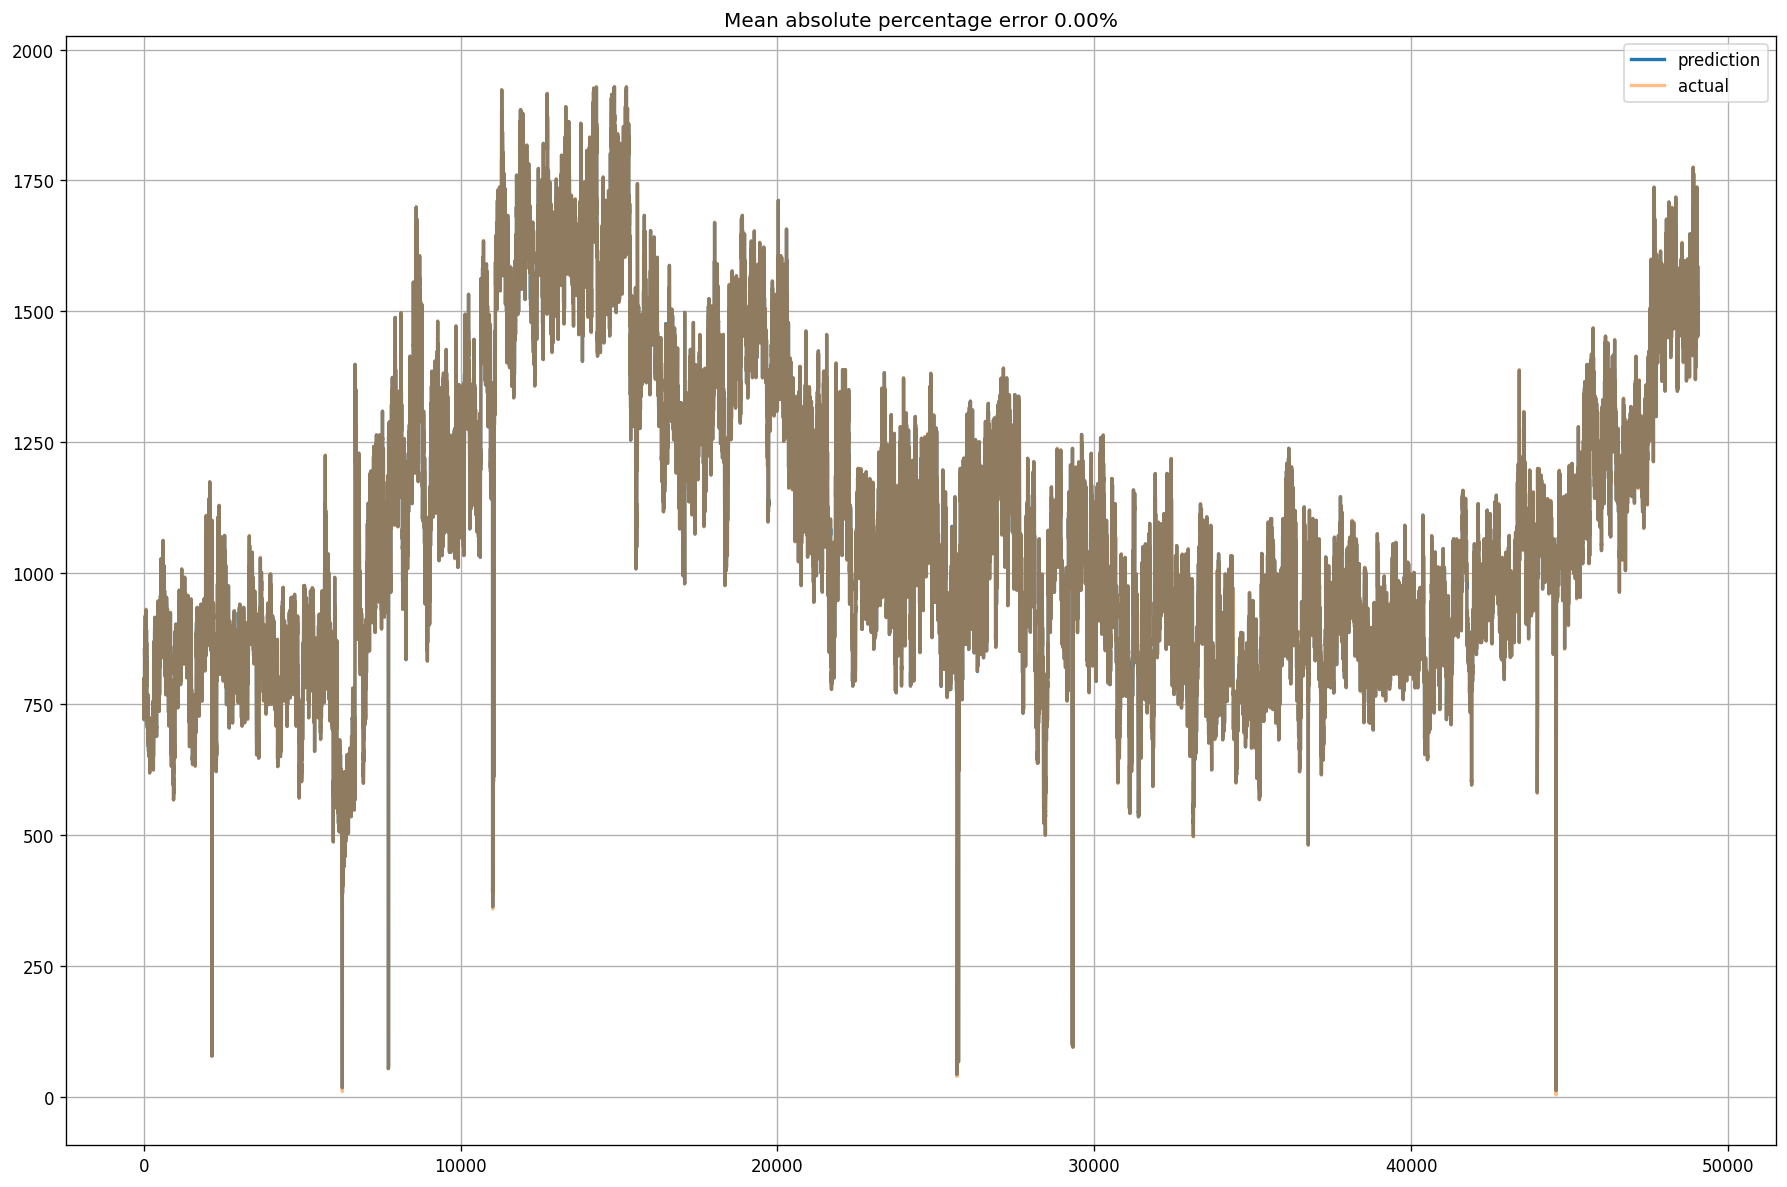

In [146]:
def plotModelTrainingResults(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(y_train, prediction)
    mae_error_var = mean_absolute_error(y_train, prediction)
    mse_error_var = mean_squared_error(y_train, prediction, squared=True)
    rmse_error_var = mean_squared_error(y_train, prediction, squared=False)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mape_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_train, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
train_results, train_mape_error_var, train_mae_error_var, train_mse_error_var, train_rmse_error_var = plotModelTrainingResults(ensemble_model)

In [147]:
print('MAPE: ' , train_mape_error_var)
print('MAE: ', train_mae_error_var)
print('MSE: ', train_mse_error_var)
print('RMSE: ', train_rmse_error_var)

MAPE:  0.0005218678657526116
MAE:  0.4617821675639613
MSE:  0.391042579932413
RMSE:  0.6253339747146424


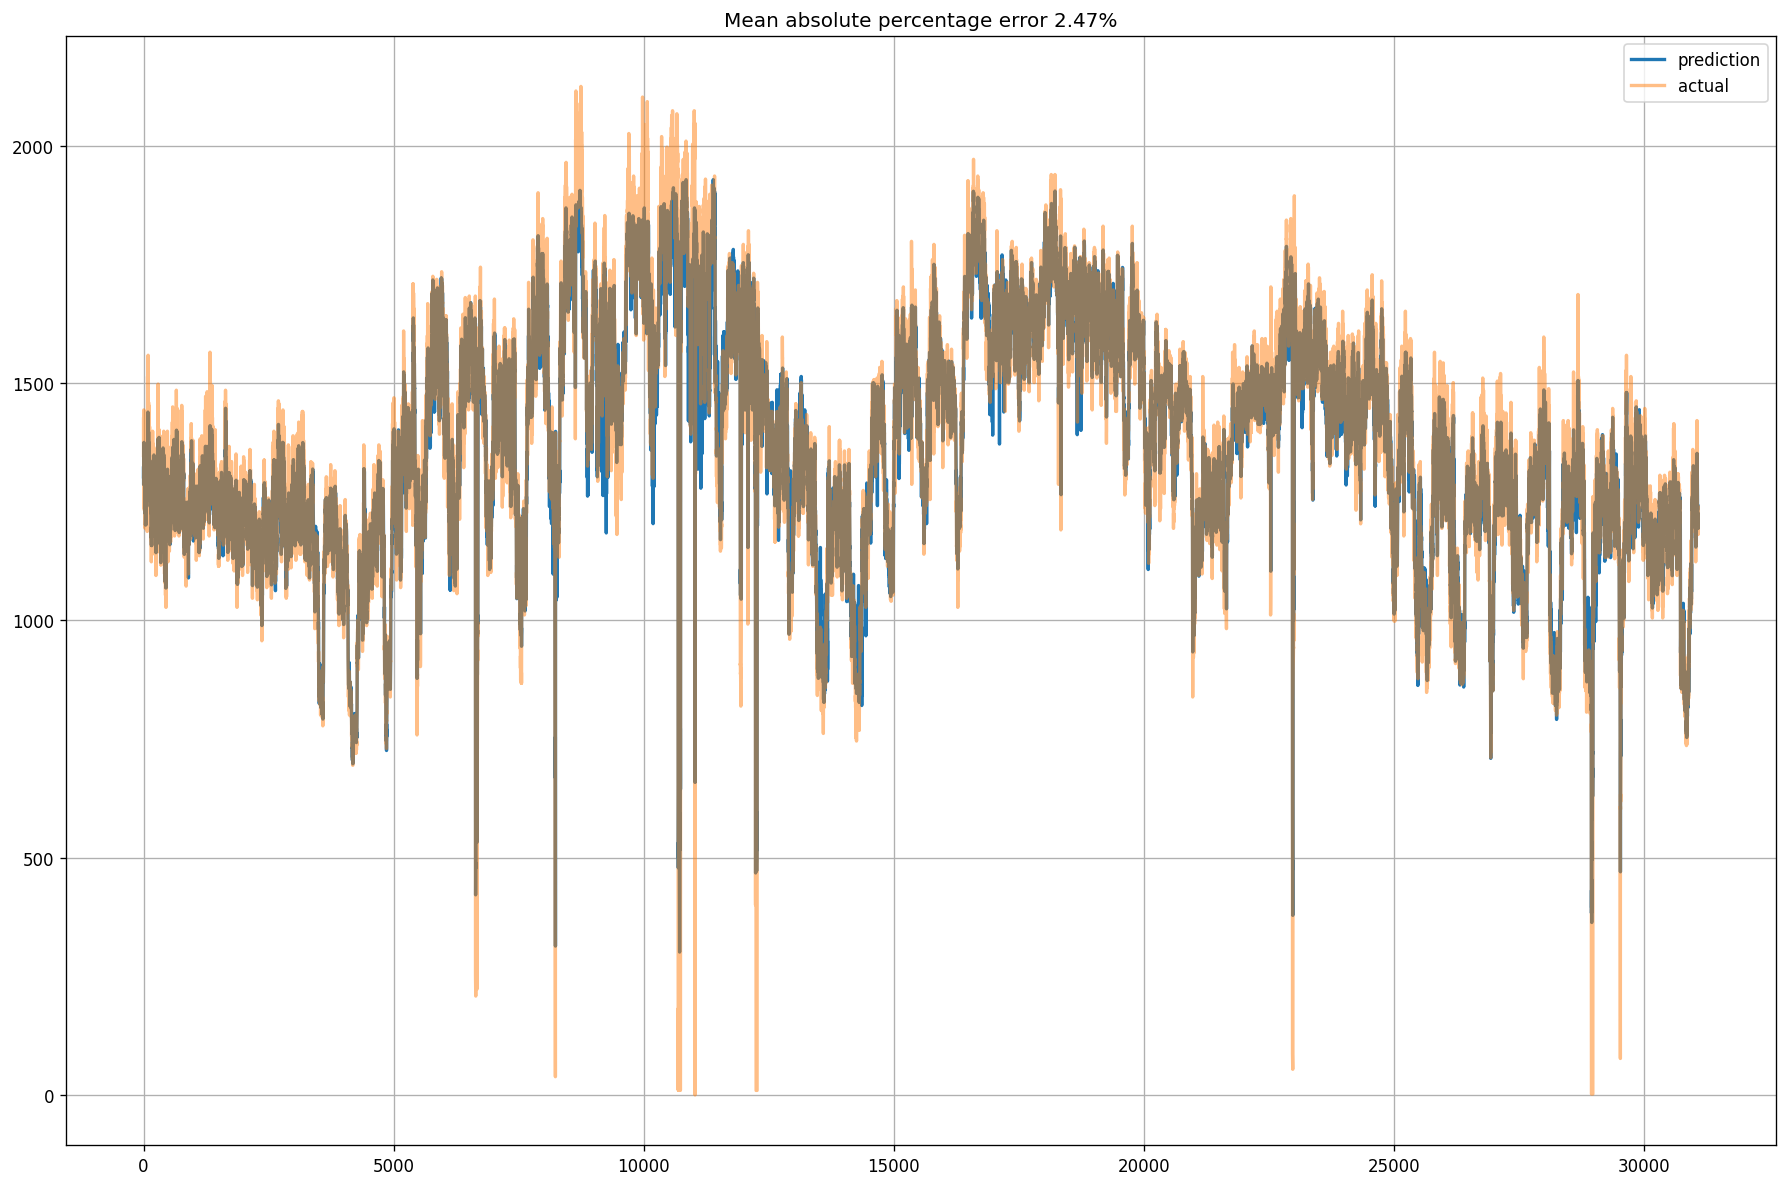

In [210]:
def plotModelPredictions(model, X_train=X_train, X_test=X_test):
  
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction, label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0, alpha=0.5)

    mape_error_var = mean_absolute_percentage_error(y_test, prediction)
    mae_error_var = mean_absolute_error(y_test, prediction)
    mse_error_var = mean_squared_error(y_test, prediction, squared=True)
    rmse_error_var = mean_squared_error(y_test, prediction, squared=False)
    
    plt.title("Mean absolute percentage error {0:.2f}%".format(mape_error_var))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
    results = pd.DataFrame({'Actual':y_test, 
                            'Prediction':prediction  
                           })
    
    return results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var
    
results, mape_error_var, mae_error_var, mse_error_var, rmse_error_var = plotModelPredictions(ensemble_model)

In [213]:
results['residual'] = results['Actual'] - results['Prediction']
results['model'] = 'Ensemble Model'
results

,Actual,Prediction,residual,model
0,1424.0,1302.24704,121.75296,Ensemble Model
1,1344.0,1324.16992,19.83008,Ensemble Model
2,1347.2,1285.81568,61.38432,Ensemble Model
3,1414.4,1338.21376,76.18624,Ensemble Model
4,1328.0,1346.81952,-18.81952,Ensemble Model
...,...,...,...,...
31074,1190.4,1225.13216,-34.73216,Ensemble Model
31075,1190.4,1213.92224,-23.52224,Ensemble Model
31076,1180.8,1216.27424,-35.47424,Ensemble Model
31077,1219.2,1193.69760,25.50240,Ensemble Model


In [214]:
print('MAPE: ' , mape_error_var)
print('MAE: ', mae_error_var)
print('MSE: ', mse_error_var)
print('RMSE: ', rmse_error_var)

MAPE:  2.47263934190527
MAE:  48.260391964026475
MSE:  5454.575059786209
RMSE:  73.85509501575507


In [215]:
test_results = pd.concat([test_results, results], axis=0) 

In [216]:
test_results['MAPE'] = (abs(test_results['Actual'] - test_results['Prediction'])/test_results['Prediction'] ) *100
test_results['MAE'] = abs(test_results['Actual'] - test_results['Prediction'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAE'>

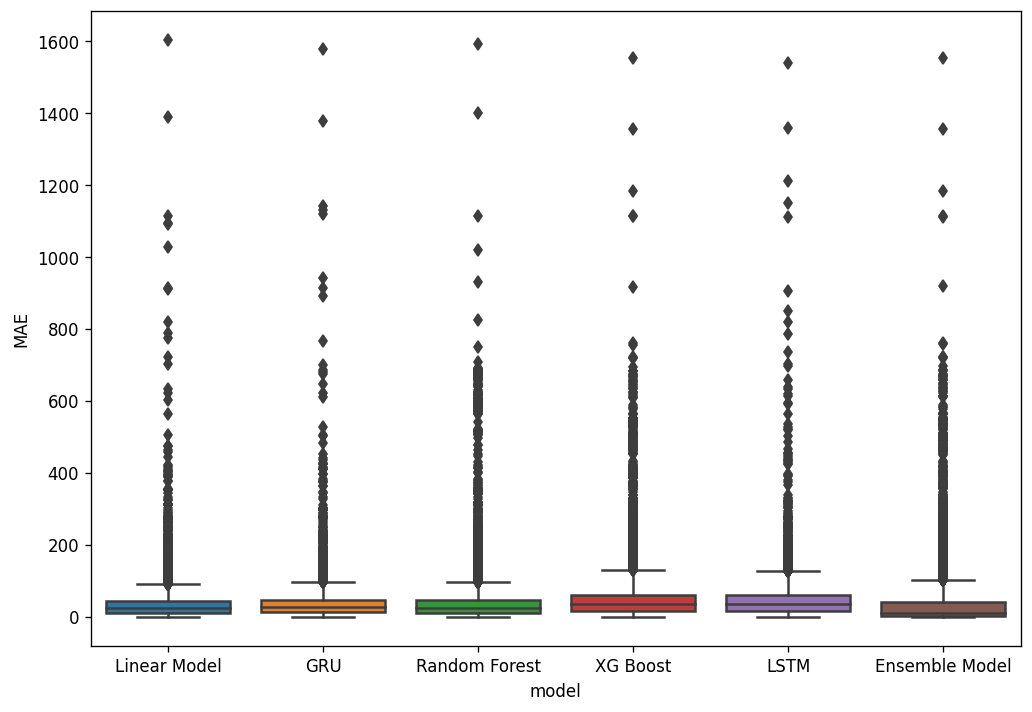

In [217]:
boxplot(test_results['model'], test_results['MAE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='MAPE'>

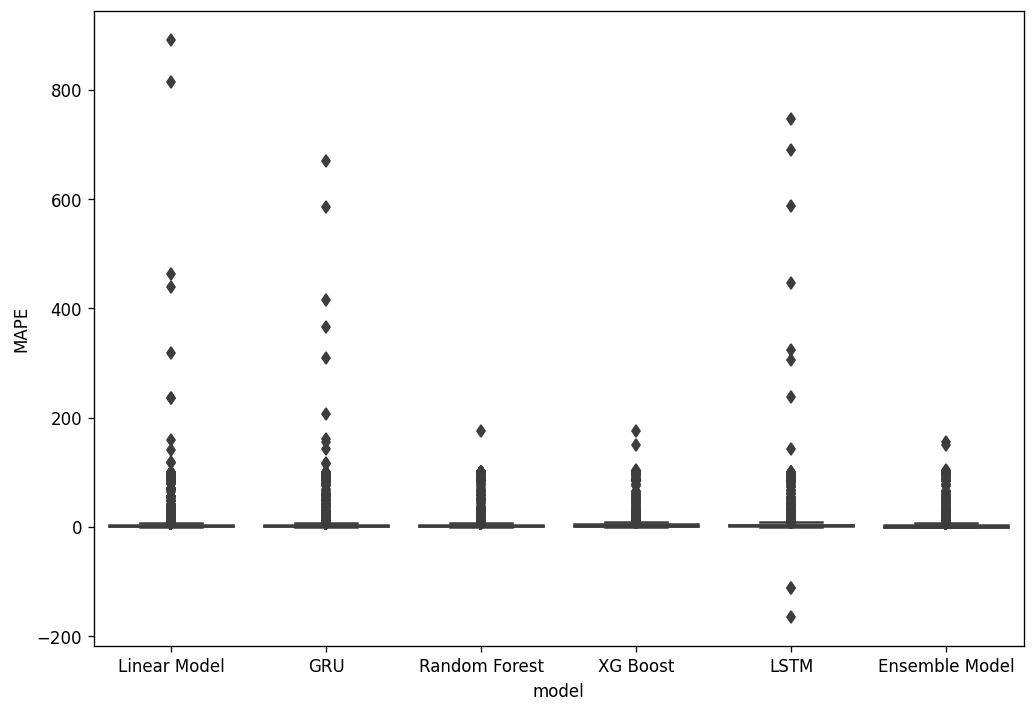

In [218]:
boxplot(test_results['model'], test_results['MAPE'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Prediction'>

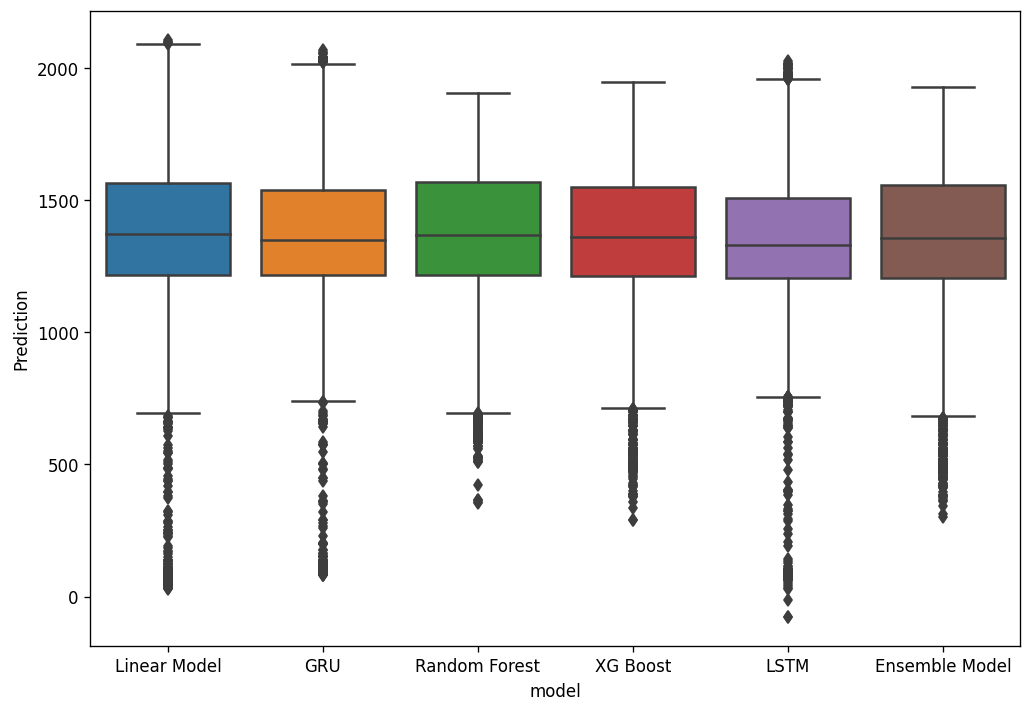

In [219]:
boxplot(test_results['model'], test_results['Prediction'])

/Users/diveshkumar/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='model', ylabel='Actual'>

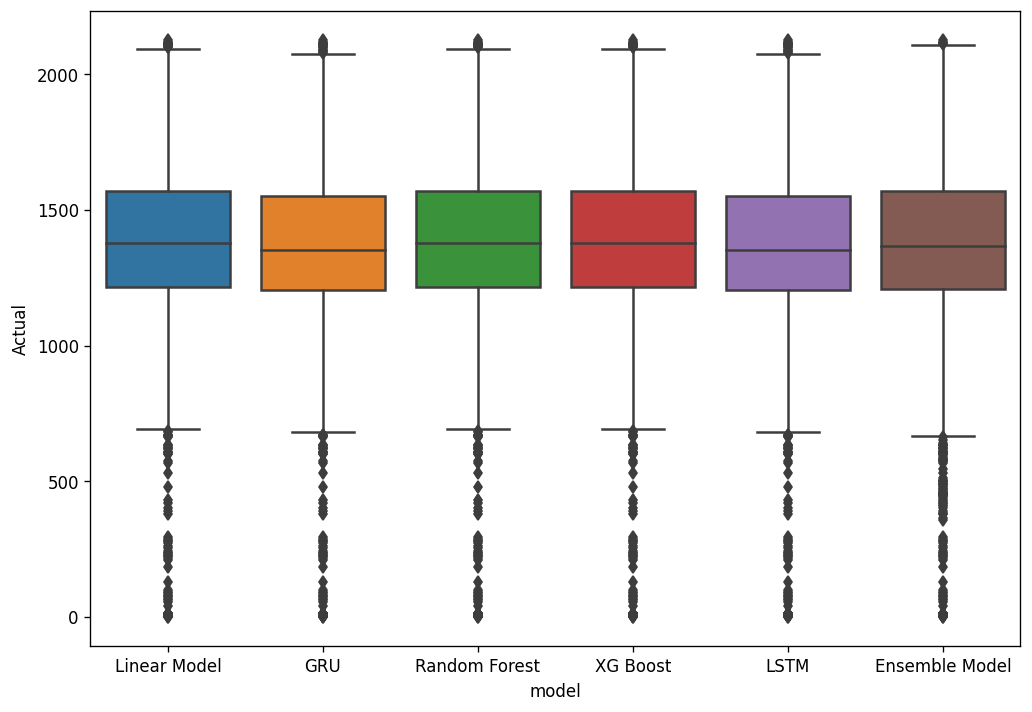

In [220]:
boxplot(test_results['model'], test_results['Actual'])

<AxesSubplot:xlabel='Feature'>

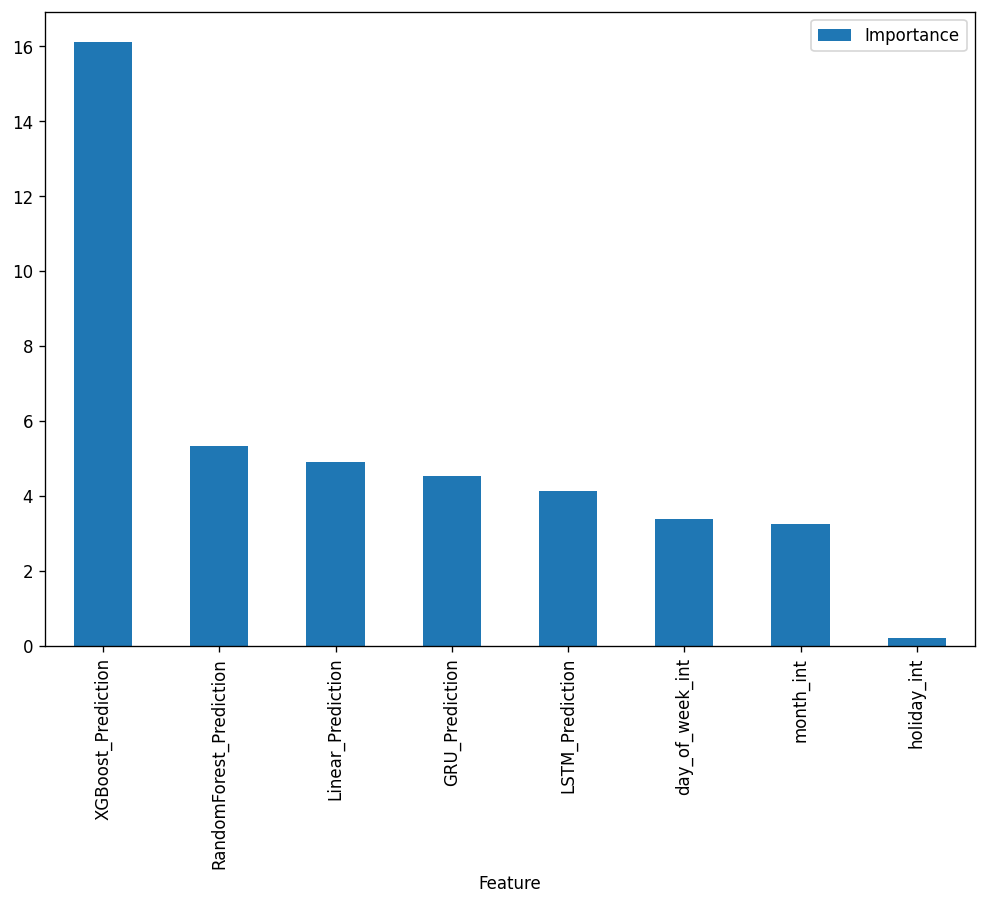

In [221]:
feature_importance = pd.concat([pd.DataFrame(ensemble_model.feature_names_in_, columns = ['Feature']), 
                                pd.DataFrame(np.log(ensemble_model.feature_importances_*10000000), columns = ['Importance'])], axis=1)
feature_importance["abs"] = feature_importance.Importance.apply(np.abs)
feature_importance = feature_importance.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
feature_importance.plot.bar(x='Feature', y='Importance', rot=90)

In [222]:
feature_importance

,Feature,Importance
3,XGBoost_Prediction,16.118040
2,RandomForest_Prediction,5.331855
0,Linear_Prediction,4.899464
1,GRU_Prediction,4.526559
4,LSTM_Prediction,4.145688
6,day_of_week_int,3.389234
5,month_int,3.247563
7,holiday_int,0.211187


In [224]:
model_index = ['Linear Model', 'GRU', 'Random Forest Model','XG Boost Model', 'LSTM','Ensemble Model']
model_results = pd.DataFrame({ 
                               'train_mape':[0.026593442401374005, 0.03356547779029653, 0.00991370280930415, 0.0014395500805660336, 0.034640355567093, 0.0005218678657526116],
                               'test_mape':[1.7063360913918577, 1.6841926532551763, 2.013655437597173, 2.470357527033101, 1.8413589056992181, 2.47263934190527 ]
                             }, index=model_index)
model_results

,train_mape,test_mape
Linear Model,0.026593,1.706336
GRU,0.033565,1.684193
Random Forest Model,0.009914,2.013655
XG Boost Model,0.001440,2.470358
LSTM,0.034640,1.841359
Ensemble Model,0.000522,2.472639


<AxesSubplot:>

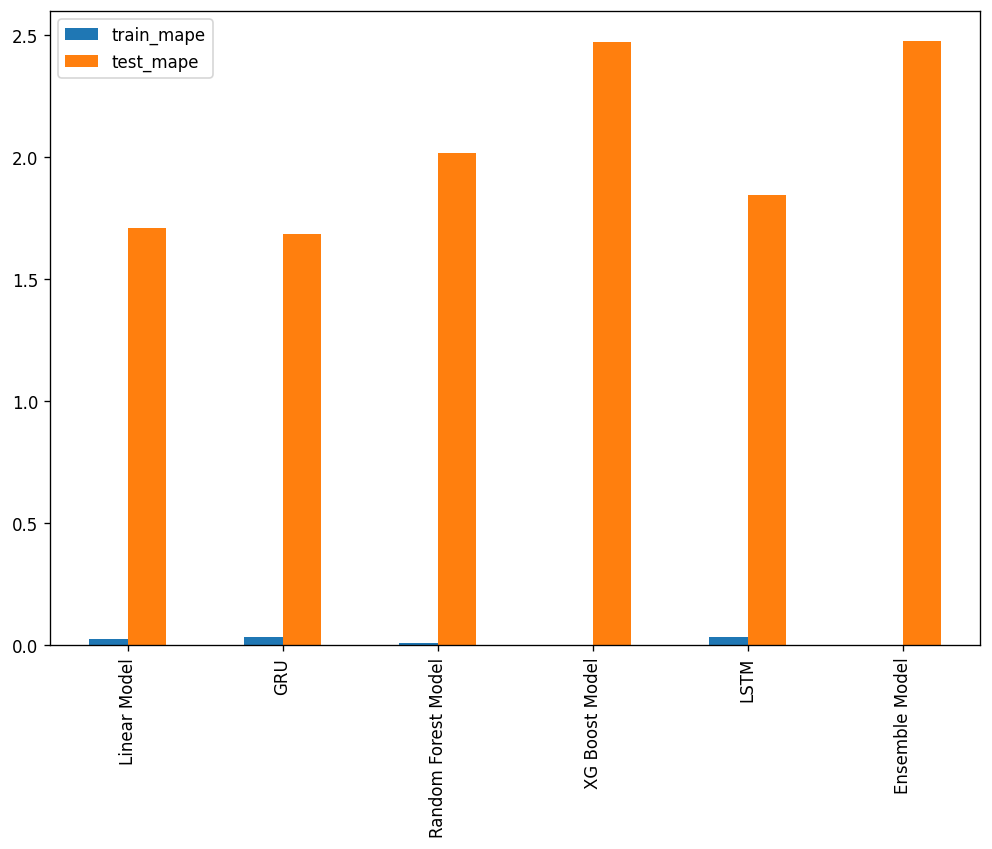

In [225]:
model_results.plot.bar()